In [143]:
from docx import Document
import pandas as pd
import docx.document
import docx.oxml.table
import docx.oxml.text.paragraph
import docx.table
import docx.text.paragraph
import re
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


##### Data for doc and docx files

In [3]:
document = Document('../data/input-word-document.docx')

In [4]:
def iter_paragraphs(parent, recursive=True):
    """
    Yield each paragraph and table child within *parent*, in document order.
    Each returned value is an instance of Paragraph. *parent*
    would most commonly be a reference to a main Document object, but
    also works for a _Cell object, which itself can contain paragraphs and tables.
    """
    if isinstance(parent, docx.document.Document):
        parent_elm = parent.element.body
    elif isinstance(parent, docx.table._Cell):
        parent_elm = parent._tc
    else:
        raise TypeError(repr(type(parent)))

    for child in parent_elm.iterchildren():
        if isinstance(child, docx.oxml.text.paragraph.CT_P):
            yield docx.text.paragraph.Paragraph(child, parent)
        elif isinstance(child, docx.oxml.table.CT_Tbl):
            if recursive:
                table = docx.table.Table(child, parent)
                yield table
        else:
            print(child)


Output File

In [104]:
document = Document('output-word-document.docx')
df = pd.DataFrame(columns=['Text', 'Contains Image', 'Contains Table'])
for paragraph in iter_paragraphs(document):
    image = 0
    table = 0
    if isinstance(paragraph, docx.text.paragraph.Paragraph):
        text = paragraph.text
        if 'graphicData' in paragraph._p.xml:
            image = 1
    elif isinstance(paragraph, docx.table.Table):
        table = 1
        text = ""
        for row in paragraph.rows:
            for cell in row.cells:
                temp = cell.text
                temp = temp.replace('\n', '')
                text += temp

    df = df.append({'Text': text, 'Contains Image': image,
                    'Contains Table': table}, ignore_index=True)


<CT_SectPr '<w:sectPr>' at 0x1a616a87d18>


In [162]:
# extracting information
startreg = [r"<<START_HEADING>>.*",
            r"<<START_SUBHEADING>>.*", r"<<START_SECTION>>.*"]
endreg = [r".*<<END_HEADING>>", r".*<<END_SUBHEADING>>", r".*<<END_SECTION>>"]


def complete_tags(df):
    prev_startTag = None
    prev_endTag = None
    for index, row in df.iterrows():
        curr_startTag = None
        curr_endTag = None
        for regex_start, regex_end in zip(startreg, endreg):
            if re.compile(regex_start).match(row['text']):
                curr_startTag = regex_start[:-2]  # to account for .*
            if re.compile(regex_end).match(row['text']):
                curr_endTag = regex_end[2:]  # to account for .*


        if curr_startTag == None and curr_endTag == None:
            if prev_startTag == None and prev_endTag == None:
                # do nothing
                df.loc[index, 'extracted_text'] = df.loc[index, 'text']
            elif prev_startTag and prev_endTag == None:
                curr_startTag = prev_startTag
                curr_endTag = prev_endTag
                df.loc[index, 'text'] = curr_startTag + row['text'] + \
                    endreg[startreg.index(curr_startTag+r'.*')][2:]
                regex = curr_startTag + \
                    r"(?P<text>.*)" + \
                    endreg[startreg.index(curr_startTag+r'.*')][2:]
                pattern = re.compile(regex)
                try:
                    extract_text = pattern.search(
                        df.loc[index, 'text']).group(1)
                except:
                    print(row['text'])
                    break
                df.loc[index, 'extracted_text'] = extract_text
                df.loc[index, 'class'] = startreg.index(curr_startTag+r'.*')

        elif curr_startTag and curr_endTag:
            regex = curr_startTag + r"(?P<text>.*)" + curr_endTag
            pattern = re.compile(regex)
            try:
                extract_text = pattern.search(df.loc[index, 'text']).group(1)
            except:
                print(row['text'])
                break
            df.loc[index, 'extracted_text'] = extract_text
            df.loc[index, 'class'] = startreg.index(curr_startTag+r'.*')
            curr_startTag = None
            curr_endTag = None

        elif curr_startTag and curr_endTag == None:
            df.loc[index, 'text'] = row['text'] + \
                endreg[startreg.index(curr_startTag+r'.*')][2:]
            regex = curr_startTag + \
                r"(?P<text>.*)" + \
                endreg[startreg.index(curr_startTag+r'.*')][2:]
            pattern = re.compile(regex)
            try:
                extract_text = pattern.search(df.loc[index, 'text']).group(1)
            except:
                print(row['text'])
                break
            df.loc[index, 'extracted_text'] = extract_text
            df.loc[index, 'class'] = startreg.index(curr_startTag+r'.*')

        elif curr_startTag == None and curr_endTag:
            df.loc[index, 'text'] = startreg[endreg.index(
                r'.*'+curr_endTag)][:-2] + row['text']
            regex = startreg[endreg.index(
                r'.*'+curr_endTag)][:-2] + r"(?P<text>.*)" + curr_endTag
            pattern = re.compile(regex)
            try:
                extract_text = pattern.search(df.loc[index, 'text']).group(1)
            except:
                print(row['text'])
                break
            df.loc[index, 'extracted_text'] = extract_text
            df.loc[index, 'class'] = endreg.index(r'.*'+curr_endTag)
            curr_startTag = None
            curr_endTag = None

        prev_startTag = curr_startTag
        prev_endTag = curr_endTag

    return df


In [111]:
df2 = df.copy()
df2.columns = ['text', 'contains_image', 'contains_table']
df2 = df2.reindex(columns=['text', 'contains_image',
                           'contains_table', 'extracted_text', 'class'])

In [112]:
complete_tags(df2)

,text,contains_image,contains_table,extracted_text,class
0,▼This medicinal product is subject to addit...,0,0,▼This medicinal product is subject to addit...,NaN
1,<<START_HEADING>>AUSTRALIAN PRODUCT INFORMATIO...,0,0,AUSTRALIAN PRODUCT INFORMATION,0.0
2,<<START_SUBHEADING>>IMFINZI®<<END_SUBHEADING>>,0,0,IMFINZI®,1.0
3,,0,0,,NaN
4,<<START_SUBHEADING>> (durvalumab) <<END_SUBHEA...,0,0,(durvalumab),1.0
...,...,...,...,...,...
472,<<START_SECTION>>Summary table of changes <<EN...,0,0,Summary table of changes,2.0
473,<<START_SECTION>>Section changed Summary of ne...,0,1,Section changed Summary of new information 4.1...,2.0
474,<<START_SECTION>>© AstraZeneca 2021 <<END_SECT...,0,0,© AstraZeneca 2021,2.0
475,<<START_SECTION>> Doc ID-003924983 v14 <<END_S...,0,0,Doc ID-003924983 v14,2.0


In [181]:
def feature_extraction(df,drop_section = True):
    df_new = df[['extracted_text', 'class',
                 'contains_image', 'contains_table']]
    df_new.dropna(axis=0, subset=['class'], inplace=True)
    df_new['extracted_text'] = df_new['extracted_text'].str.strip()
    df_new = df_new[(df_new['extracted_text'] != '') |
                    (df_new['contains_image'] != 0)]
    df_new.reset_index(drop=True, inplace=True)
    df_new['extracted_text'] = df_new['extracted_text'].astype(str)
    import nltk
    from nltk.corpus import stopwords
    df_new['words'] = df_new['extracted_text'].apply(lambda x: len(x.split()))
    stop_words = set(stopwords.words('english'))
    df_new['stopwords'] = df_new['extracted_text'].apply(
        lambda x: len(set(x.split()) & stop_words))
    df_new['endswithdot'] = df_new['extracted_text'].str.endswith('.')
    df_new['endswithdot'] = df_new['endswithdot'].astype(int)
    df_new['Table'] = df_new['extracted_text'].str.contains('Table')
    df_new['Table'] = df_new['Table'].astype(int)
    df_new['contains section'] = df_new['extracted_text'].str.contains(
        'Section')
    df_new['contains section'] = df_new['contains section'].astype(int)
    df_new['contains percentage'] = df_new['extracted_text'].str.contains('%')
    df_new['contains percentage'] = df_new['contains percentage'].astype(int)
    df_new['Uppercase'] = df_new['extracted_text'].str.findall(
        r'[A-Z]').str.len()
    df_new['Lowercase'] = df_new['extracted_text'].str.findall(
        r'[a-z]').str.len()
    df_new['percentage capital'] = (
        df_new['Uppercase']*100)/(df_new['Lowercase']+df_new['Uppercase'])
    if drop_section:
        df_new.drop(columns=['Uppercase', 'Lowercase','contains section'], inplace=True)
    else:
        df_new.drop(columns=['Uppercase', 'Lowercase'], inplace=True)
    df_new['percentage capital'] = df_new['percentage capital'].fillna(0)
    df_new['class'] = df_new['class'].astype(int)
    import re

    def fun_starts_integer(x):
        reg = r"\d+?\s.*"
        pat = re.compile(reg)
        if pat.match(x) == None:
            return 0
        else:
            return 1

    def fun_starts_decimal(x):
        reg = r"\d+\.\d+?\s.*"
        pat = re.compile(reg)
        if pat.match(x) == None:
            return 0
        else:
            return 1
    df_new['starts_integer'] = df_new['extracted_text'].apply(
        lambda x: fun_starts_integer(x))
    df_new['starts_decimal'] = df_new['extracted_text'].apply(
        lambda x: fun_starts_decimal(x))
    return df_new


In [139]:
df2.to_csv('outputv3.csv')
df2 = pd.read_csv('outputv3.csv')

In [140]:
df_final = feature_extraction(df2)
df_final.to_csv('feature_output_final.csv')


C:\Users\VIGNESH S\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\VIGNESH S\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Random Forests 

In [141]:
df = pd.read_csv('feature_output_final.csv')
df.drop(columns=df.columns[0], axis=1, inplace=True)


In [144]:
X = df.drop(columns=['extracted_text', 'class'])
y = df['class']


In [145]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y)


In [146]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    max_depth=9, random_state=0, class_weight='balanced')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [147]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, clf.predict(X_train))


0.9871244635193133

C:\Users\VIGNESH S\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


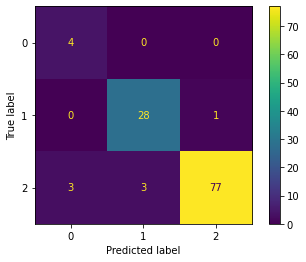

In [148]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(clf, X_test, y_test)
plt.show()


In [149]:
feature_imp = pd.Series(clf.feature_importances_,
                        index=X_train.columns).sort_values(ascending=False)
feature_imp


percentage capital     0.387536
words                  0.248446
starts_integer         0.157429
stopwords              0.089979
endswithdot            0.075684
starts_decimal         0.013368
Table                  0.011194
contains_image         0.008900
contains percentage    0.005523
contains_table         0.001940
dtype: float64

It was found that the feature 'contains the word section' was not important. Hence it was dropped in feature engineering.

In [150]:
import joblib
file_name1 = "random_forest_vfinal.pkl"

# save
joblib.dump(clf, open(file_name1, "wb"))

Txt files

In [157]:
def read_lines(location):
    document = open(location, 'r')
    doc = [x.rstrip() for x in document.readlines()]
    return doc

In [158]:
doc = read_lines('output-plain-document.txt')

In [183]:
df = pd.DataFrame(columns=['Text', 'Contains Image', 'Table'])
for element in doc:
    if element != '':
        df = df.append({'Text': element, 'Contains Image': int(
            'Figure' in element), 'Table': int('Table' in element)}, ignore_index=True)

In [184]:
df2 = df.copy()
df2.columns = ['text', 'contains_image', 'contains_table']
df2 = df2.reindex(columns=['text', 'contains_image',
                           'contains_table', 'extracted_text', 'class'])


In [185]:
df2= complete_tags(df2)
df2.to_csv('output_txt.csv')

In [188]:
def feature_extraction_txt(df):
    df_new=df[['extracted_text','class','contains_image','contains_table']]
    df_new.dropna(inplace=True)
    df_new.reset_index(drop=True, inplace=True)
    df_new['extracted_text'] = df_new['extracted_text'].str.strip()
    import nltk
    from nltk.corpus import stopwords  
    df_new['words'] = df_new['extracted_text'].apply(lambda x: len(x.split()))
    stop_words = set(stopwords.words('english'))
    df_new['stopwords'] = df_new['extracted_text'].apply(lambda x: len(set(x.split()) & stop_words))
    df_new['endswithdot']=df_new['extracted_text'].str.endswith('.')
    df_new['endswithdot']=df_new['endswithdot'].astype(int)
    df_new['Table']=df_new['extracted_text'].str.contains('Table')
    df_new['Table']=df_new['Table'].astype(int)
    df_new['contains section']=df_new['extracted_text'].str.contains('Section')
    df_new['contains section']=df_new['contains section'].astype(int)
    df_new['contains percentage']=df_new['extracted_text'].str.contains('%')
    df_new['contains percentage']=df_new['contains percentage'].astype(int)
    df_new['Uppercase'] = df_new['extracted_text'].str.findall(r'[A-Z]').str.len()
    df_new['Lowercase'] = df_new['extracted_text'].str.findall(r'[a-z]').str.len()
    df_new['percentage capital']=(df_new['Uppercase']*100)/(df_new['Lowercase']+df_new['Uppercase'])
    df_new.drop(columns=['Uppercase','Lowercase'],inplace=True)
    df_new.dropna(inplace=True)
    df_new['class']=df_new['class'].astype(int)
    import re
    def fun_starts_integer(x):
        reg = r"\d+?\s.*"
        pat  = re.compile(reg)
        if pat.match(x)==None:
            return 0
        else:
            return 1
    def fun_starts_decimal(x):
        reg = r"\d+\.\d+?\s.*"
        pat  = re.compile(reg)
        if pat.match(x)==None:
            return 0
        else:
            return 1
    df_new['starts_integer']=df_new['extracted_text'].apply(lambda x:fun_starts_integer(x))
    df_new['starts_decimal']=df_new['extracted_text'].apply(lambda x:fun_starts_decimal(x))
    return df_new

In [191]:
df = pd.read_csv('output_txt.csv')
df_final = feature_extraction_txt(df)
df_final.to_csv('features_txt.csv')


C:\Users\VIGNESH S\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\VIGNESH S\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\VIGNESH S\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [192]:
data = 'features_txt.csv'
df = pd.read_csv(data)
df.head()

,Unnamed: 0,extracted_text,class,contains_image,contains_table,words,stopwords,endswithdot,Table,contains section,contains percentage,percentage capital,starts_integer,starts_decimal
0,0,AUSTRALIAN PRODUCT INFORMATION,0,0,0,3,0,0,0,0,0,100.0,0,0
1,1,IMFINZI?,1,0,0,1,0,0,0,0,0,100.0,0,0
2,2,(durvalumab),1,0,0,1,0,0,0,0,0,0.0,0,0
3,3,1 \tNAME OF THE MEDICINE,0,0,0,5,0,0,0,0,0,100.0,1,0
4,4,Durvalumab,2,0,0,1,0,0,0,0,0,10.0,0,0


In [193]:
df.drop('Unnamed: 0', axis=1, inplace=True)


In [171]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # for data visualization purposes
import seaborn as sns  # for statistical data visualization


## EDA

In [194]:
# df[df['contains section']!=0]
df[df['class'] == 2]
# sum(df['contains section']!=0)


,extracted_text,class,contains_image,contains_table,words,stopwords,endswithdot,Table,contains section,contains percentage,percentage capital,starts_integer,starts_decimal
4,Durvalumab,2,0,0,1,0,0,0,0,0,10.000000,0,0
6,Each vial of IMFINZI concentrated solution for...,2,0,0,17,3,1,0,0,0,10.000000,0,0
7,"For the full list of excipients, see Section 6.1.",2,0,0,9,2,1,0,1,0,5.555556,0,0
9,"Sterile, preservative free, clear to opalescen...",2,0,0,19,4,1,0,0,0,0.806452,0,0
13,IMFINZI (durvalumab) is indicated for the trea...,2,0,0,23,7,1,0,0,0,7.500000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,Section updated as a consequence of the deleti...,2,0,0,14,4,1,0,1,0,6.493506,0,0
688,New ?1500 mg every 4 weeks? dosage for NSCLC h...,2,0,0,12,3,1,0,0,0,14.634146,0,0
689,?1500 mg every 4 weeks? dosage added as per CD...,2,0,0,15,1,1,0,0,0,9.756098,0,0
690,? AstraZeneca 2021,2,0,0,3,0,0,0,0,0,18.181818,0,0


The percentage of section class in target feature is 85.84%


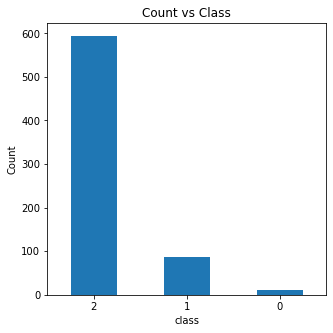

In [195]:
plt.figure(figsize=(5, 5))
df['class'].value_counts().plot(kind='bar')
plt.xlabel('class'), plt.ylabel('Count'), plt.xticks(rotation='horizontal')
plt.title("Count vs Class")
print("The percentage of section class in target feature is {0:.2f}%".format(
    df['class'].value_counts()[2]/sum(df['class'].value_counts())*100))


In [196]:
df['class'].value_counts()


2    594
1     87
0     11
Name: class, dtype: int64

## Model training

In [197]:
X = df.drop(['contains_table', 'extracted_text', 'class'], axis=1)
y = df['class']


In [198]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


In [199]:
y_train.value_counts()


2    415
1     61
0      8
Name: class, dtype: int64

In [200]:
y_test.value_counts()


2    179
1     26
0      3
Name: class, dtype: int64

##### SVM with default hyperparameters
Default hyperparameter means C = 1.0, kernel = rbf and gamma = auto among other parameters.

In [202]:
from sklearn.svm import SVC
# import metrics to compute accuracy
from sklearn.metrics import accuracy_score
# instantiate classifier with default hyperparameters
svc = SVC(random_state=42)
# fit classifier to training set
svc.fit(X_train, y_train)
# make predictions on test set
y_pred = svc.predict(X_test)
# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(
    accuracy_score(y_test, y_pred)))


Model accuracy score with default hyperparameters: 0.8606


##### SVM with rbf kernel, C=100

In [203]:
# instantiate classifier with rbf kernel and C=100
svc = SVC(C=100.0, random_state=42)
# fit classifier to training set
svc.fit(X_train, y_train)
# make predictions on test set
y_pred = svc.predict(X_test)
# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=100.0 : {0:0.4f}'. format(
    accuracy_score(y_test, y_pred)))


Model accuracy score with rbf kernel and C=100.0 : 0.8894


In [204]:
svc.get_params()


{'C': 100.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

##### SVM with rbf kernel, C=1000

In [205]:
# instantiate classifier with rbf kernel and C=1000
svc = SVC(C=1000.0, random_state=42)
# fit classifier to training set
svc.fit(X_train, y_train)
# make predictions on test set
y_pred = svc.predict(X_test)
# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=100.0 : {0:0.4f}'. format(
    accuracy_score(y_test, y_pred)))


Model accuracy score with rbf kernel and C=100.0 : 0.8894


###### SVM with linear kernel and C=1.0

In [206]:
# instantiate classifier with linear kernel and C=1.0
linear_svc = SVC(kernel='linear', C=1.0, random_state=42)
# fit classifier to training set
linear_svc.fit(X_train, y_train)
# make predictions on test set
y_pred_test = linear_svc.predict(X_test)
# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1.0 : {0:0.4f}'. format(
    accuracy_score(y_test, y_pred_test)))


Model accuracy score with linear kernel and C=1.0 : 0.8894


###### SVM with linear kernel and C=100.0

In [207]:
# instantiate classifier with linear kernel and C=100.0
linear_svc = SVC(kernel='linear', C=100.0, random_state=42)
# fit classifier to training set
linear_svc.fit(X_train, y_train)
# make predictions on test set
y_pred_test = linear_svc.predict(X_test)
# compute and print accuracy score
print('Model accuracy score with linear kernel and C=100.0 : {0:0.4f}'. format(
    accuracy_score(y_test, y_pred_test)))


Model accuracy score with linear kernel and C=100.0 : 0.8894


In [208]:
linear_svc.get_params()


{'C': 100.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

#### Grid Search

In [ ]:
# Parameter grid
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
svm_param_grid = {'C': np.logspace(1, 7, num=30, base=2), 'gamma': [
    0.1, 0.01, 0.001, 1], "kernel": ["rbf", "linear"]}
# svm_param_grid = {'C': np.logspace(3,6,num=20,base = 2)}

# Create SVM grid search classifier
clf = SVC(random_state=42)
svm_grid = GridSearchCV(clf, svm_param_grid, cv=4, verbose=2, n_jobs=-1)

# Train the classifier
svm_grid.fit(X_train, y_train)

print("Best Parameters:\n", svm_grid.best_params_)
print("Mean cross-validated score of the best_estimator: ", svm_grid.best_score_)

# Select best svc
best_svc = svm_grid.best_estimator_

# Make predictions using the optimised parameters
svm_pred = best_svc.predict(X_test)

print('SVM accuracy:', round(accuracy_score(y_test, svm_pred), 3))
cm_svm = confusion_matrix(y_test, svm_pred)

ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax=ax, fmt='g', cmap='Greens')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('SVM Confusion Matrix')


In [ ]:
dfr = pd.DataFrame(svm_grid.cv_results_)
dfr[dfr['rank_test_score'] == 1]


In [ ]:
import joblib
joblib.dump(svm_grid, 'svm_grid_txt.pkl')
joblib.dump(svm_grid.best_estimator_, 'best_svc_txt.pkl')


## Saving predictions

In [ ]:
y_predicted = best_svc.predict(X)
X['extracted_text'] = df['extracted_text']
X['True_class'] = df['class']
X['Predicted_class'] = y_predicted
X.to_csv('Predictions_txt_svm.csv')

In [ ]:
df[['extracted_text', 'class']]

In [ ]:
X